# b jet characteristics

Having accurate modeling of the b jet characteristics is very important given the evidence that the dimuon mass excess may be correlated with a corresponding excess in the $\mu\mu$ + b jet mass.  


## b jet efficiencies

I will first focus on measuring the efficiency of b tagging (using the CSV tagger with the "tight" working point (CSV > 0.898).  The b tagging POG provides data to MC scale factors, but it is necessary for analyzers to calculate their own b tag efficiencies in MC since they will depend on both the composition of the sample under consideration and the selection that is applied.

I will consider 8 TeV MC and then 13 TeV MC.  The samples considered here will be $t\bar{t}$, Drell-Yan, and a B' signal sample.

In [1]:
# imports and initial configuration
%cd '/home/naodell/work/CMS/amumu'
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import nllfitter.plot_tools as pt

pt.set_new_tdr()
matplotlib.rcParams['figure.figsize'] = (8,8)

/home/naodell/work/CMS/amumu


In [8]:
# get the datasets

ntuple_dir  = 'data/flatuples/mumu_2012'
datasets    = [
               'ttbar_lep', 'ttbar_semilep',
               'zjets_m-50', 'zjets_m-10to50',
               'bprime_xb'
              ]
cuts        = 'lepton1_pt > 25 and abs(lepton1_eta) < 2.1 \
               and lepton2_pt > 5 and abs(lepton2_eta) < 2.4 \
               and lepton1_q != lepton2_q \
               and 12 < dilepton_mass < 70'

data_manager = pt.DataManager(input_dir     = ntuple_dir,
                              dataset_names = datasets,
                              selection     = 'mumu',
                              period        = 2012,
                              cuts          = cuts
                             )

Loading dataframes: 100%|███████████████| 5.00/5.00 [00:05<00:00, 1.07s/it]


The datasets used here have some preselection requirements:

* the IsoMu24_eta2p1 trigger must have fired
* there must be at least one good PV
* at least two tight ID, loose track isolated muons
* lead muon $p_{T} > 25$ and $|\eta| < 2.1$
* trailing muon $p_{T} > 5$ and $|\eta| < 2.4$
* $q_{\mu1} \neq q_{\mu2}$ 
* $12 < M_{\mu\mu} < 70$

The jet that is used for measuring the efficiencies is reconstructed using the anti-$k^{T}$ algorithm and clustering particle-flow objects within a cone of size dR=0.5.  The jet flavor is determined by matching a reconstructed PF jet to a jet that has been reconstructed by clustering generator level partons (_include link to CMS mc flavor matching_).  The MC flavor matching greatly simplifies the efficiency measurement in the simulation.

The definition for our denominator object is:

* PF jet with $p_{T} > 10$ and $|\eta| < 2.4$
* MC flavor is 5 or -5 (PDG ID for a b quark)

The numerator object is a denominator object with the additional requirement that:

* CSV > 0.898 (tight b tag POG WP)

It will be interesting to measure the efficiency as both a function of $p_{T}$ and $\eta$.

In [9]:
labels = ['ttbar', 'zjets', 'bprime_xb']
fmts = {'ttbar': 'ko', 'zjets': 'bo', 'bprime_xb': 'ro'}
data = {}
for l in labels:
    df = data_manager.get_dataframe(l)
    df = df.query('gen_bjet_pt > 10 and abs(gen_bjet_eta) < 2.4')
    df.loc[:,'tagged'] = (df['gen_bjet_tag'] > 0.898)
    data[l] = df

Let's take a look at the b tag values:

<IPython.core.display.Javascript object>


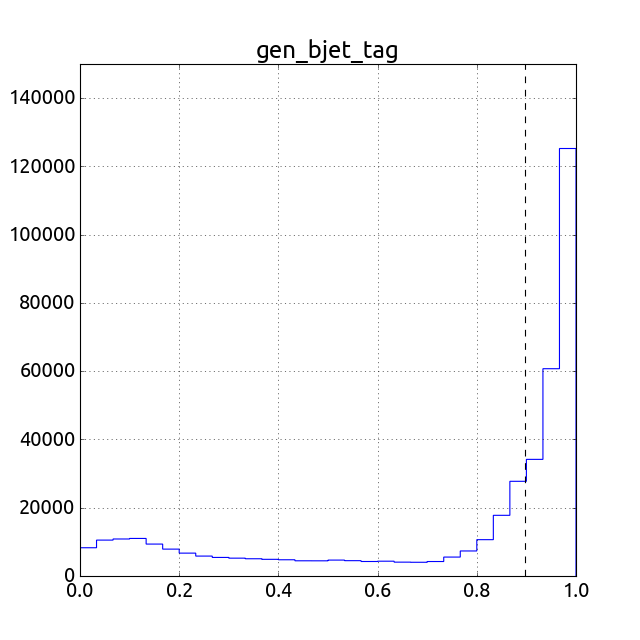

(0, 150000.0)

In [10]:
data['ttbar'].hist('gen_bjet_tag', 
                   bins=30, 
                   range=(0, 1), 
                   histtype='step'
                  )
plt.plot([0.898, 0.898], [0, 1.5e5], 'k--')
plt.ylim([0, 1.5e5])

This distribution looks pretty reasonable.  Keep in mind every event that goes into the above hisogram does have a b quark in the generator process.  Now let's measure the efficiencies.  We'll want a function that will bin the data and calculate the efficiencies, and one that will plot the result.

In [13]:
def get_efficiency(num, den, bins):
    '''
    Calculate efficiencies...
    
    Parameters:
    ===========
    num: array for numerator (subset of denominator)
    den: array for denominator
    nbins: number of bins
    xlimit: x range
    '''
    n, _ = np.histogram(num, bins=bins)
    d, b = np.histogram(den, bins=bins)
    
    x = (b[1:] + b[:-1])/2.
    x_err = (b[1:] - b[:-1])/2.
    eff = n.astype(float)/d
    eff_err = np.zeros(eff.size)
    
    return x, eff, x_err, eff_err

def efficiency_plot(data, var, labels, bins, fmts):
    '''
    Produces efficiency plots
    '''
    label_dict = {'gen_bjet_pt':r'$\sf p_{T}$',
                  'gen_bjet_eta':r'$\sf \eta$',
                  'gen_bjet_phi':r'$\sf \phi$'
                 }
    for l in labels:
        df = data[l]
        numer = df.query('tagged')[var]
        denom = df[var]
        x, eff, x_err, y_err = get_efficiency(numer.values, denom.values, 
                                              bins=bins
                                             )
        plt.errorbar(x, eff, yerr=y_err, xerr=x_err,
                     fmt=fmts[l],
                     capsize=0,
                     markersize=8.,
                     elinewidth=2
                    )
    plt.xlim([bins[0], bins[-1]])
    plt.ylim([0.25, 0.75])
    plt.xlabel(label_dict[var])
    plt.ylabel(r'$\sf \epsilon_{b\,tag}$')

    plt.legend(labels)

    plt.grid()
    plt.show()

### b tag efficiency vs. jet transverse momentum (8 TeV)

<IPython.core.display.Javascript object>


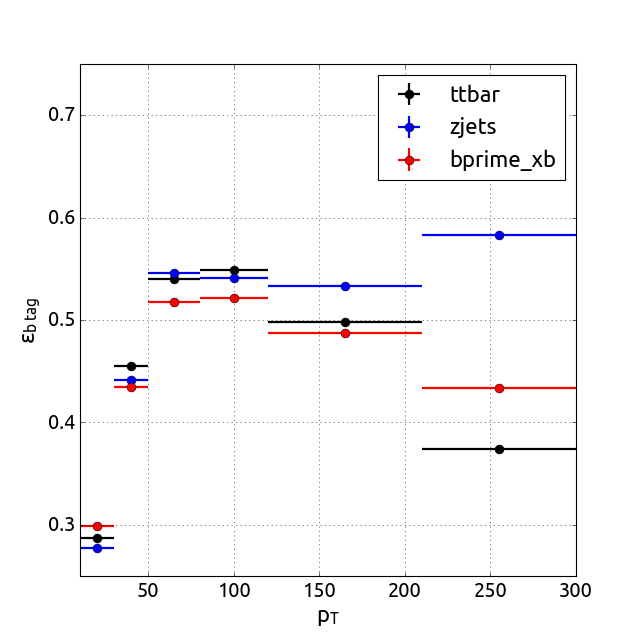

In [14]:
# efficiencies vs. pt
var = 'gen_bjet_pt'
bins = [10, 30, 50, 80, 120, 210, 300]
efficiency_plot(data, var, labels, bins, fmts)

### b tag efficiency vs. jet pseudorapidity (8 TeV)

<IPython.core.display.Javascript object>


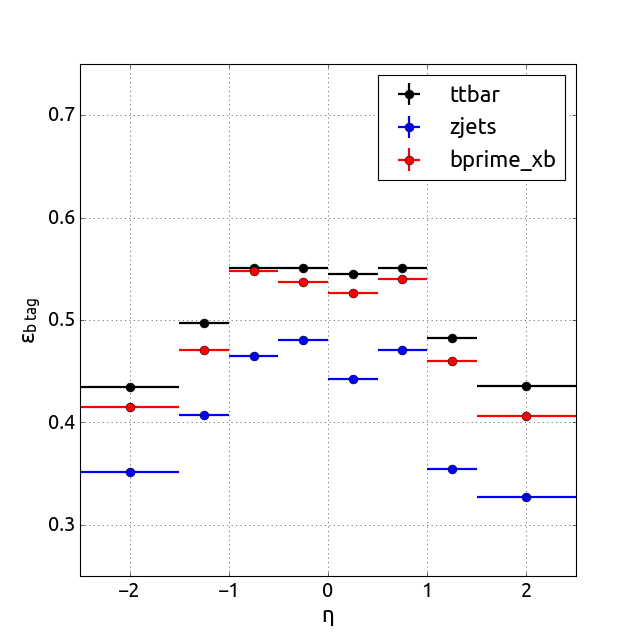

In [15]:
# efficiencies vs. pt
var = 'gen_bjet_eta'
bins = [-2.5, -1.5, -1., -0.5, 0., 0.5, 1.0, 1.5, 2.5]
efficiency_plot(data, var, labels, bins, fmts)

### b tag efficiency vs. jet azimuthal angle (8TeV)

<IPython.core.display.Javascript object>


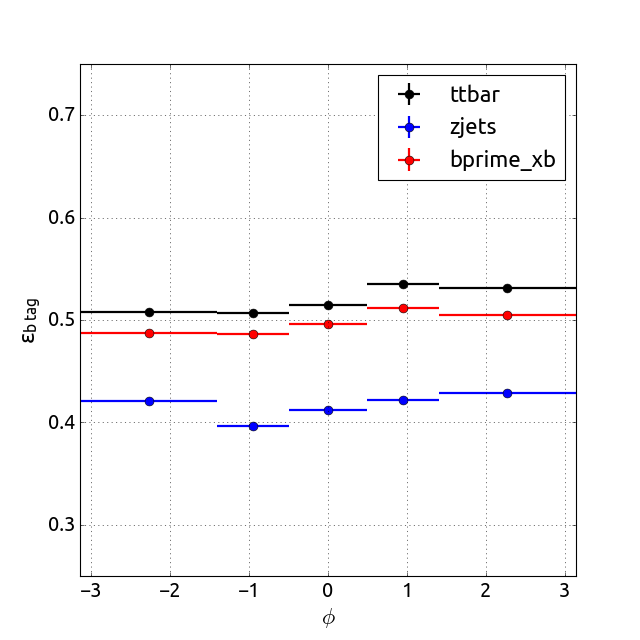

In [17]:
# efficiencies vs. phi
var = 'gen_bjet_phi'
bins = [-np.pi, -1.4, -0.5, 0.5, 1.4, np.pi]
efficiency_plot(data, var, labels, bins, fmts)